# Tia Openess Demo 2 - Quinten Bauwens

In this notebook a short demo is given of how to work with openness.

Software used:
 - Windows 10
 - Visual Studio Code
 - Python 3.11.4
 - TIA Portal 15.1:
    -  SIMATIC STEP 7 Professional - WinCC Professional v15.1 Upd5
    -  SIMATIC Step 7 Safety v15.1
    -  SIMATIC Visualization Architect v15.1
    -  SINAMICS Startdrive V15.1
    -  Tia Openess Explorer 

Versions of the Python-packages can be found in the requirements.txt file

## 1. Initializing TIA project

In [3]:
import InitTiaProject as Init
# Needed modules: InitTiaProject, json 
# Open the project
myproject, myinterface = Init.open_project(False)
#C:\Program Files\Siemens\Automation\Portal V15_1\PublicAPI\V15.1\Siemens.Engineering.dll
#C:\Temp\P712713A01\P712713A01.ap15_1

In [4]:
import json
import Siemens.Engineering as tia # Copy the Siemens.Engineering.dll to the folder of the script (current working dir.)!!
import Siemens.Engineering.HW.Features as hwf # Import the HW Features, to locate the software container
from collections import OrderedDict as od
import os
import pandas as pd

## 2. Project information

In [8]:
print('Project Information')
print(f'''
        Name: \t\t\t {myproject.Name}
        Creation time:\t\t {myproject.CreationTime}
        Last Change:\t\t {myproject.LastModified}
        Author:\t\t\t {myproject.Author}
        Last modified by:\t {myproject.LastModifiedBy}
    ''')

print('Project History')
print(f'''
        DateTime\t\t Event\t\t''')
for event in myproject.HistoryEntries:
    print('\t',event.DateTime, '\t',event.Text)


Project Information

        Name: 			 P712713A01
        Creation time:		 19/02/2018 12:30:58
        Last Change:		 19/01/2024 12:52:37
        Author:			 Imtech
        Last modified by:	 QBAUWEN1
    
Project History

        DateTime		 Event		
	 19/02/2018 12:40:55 	 Migration from STEP 7 K5.5.4.0, WinCC V7.4 to V14 SP1
	 19/02/2018 15:00:47 	 Created by user in version CPU 319F-3 PN/DP PLC migration
	 23/02/2018 14:29:31 	 Mass data import
	 23/02/2018 14:30:25 	 Mass data import
	 23/02/2018 14:31:41 	 Mass data import
	 23/02/2018 14:33:44 	 Mass data import
	 23/02/2018 15:34:40 	 Mass data import
	 1/03/2018 13:12:21 	 Mass data import
	 2/03/2018 12:11:27 	 The project was updated from project library.
	 2/03/2018 12:17:01 	 The project was updated from project library.
	 2/03/2018 12:36:59 	 Mass data import
	 2/03/2018 13:04:02 	 Mass data import
	 2/03/2018 13:25:29 	 Mass data import
	 2/03/2018 13:26:20 	 Mass data import
	 14/03/2018 13:55:30 	 Mass data import
	 14/03

In [9]:
# Needed modules: Siemens.Engineering.HW.Features
# Get all the hardware 
def give_items(device, Items=[]):
    
    for item in device.DeviceItems:
        Items.append(item)
        Items = give_items(item, Items)
    return Items

def get_devices(group, Items=[]):
    '''
    Returns all the devices of a group.
    '''
    for device in group.Devices:
        Items = give_items(device, Items)
    return Items

def get_interface_devices(projectItems, Items=None):
    '''
    Returns all the devices with an interface-service.
    '''
    if Items is None:
        Items = []
    for deviceitem in projectItems:  # for all the devices and deviceItems in the project
        network_service = tia.IEngineeringServiceProvider(deviceitem).GetService[hwf.NetworkInterface]()  # get the interface service
        if isinstance(network_service, hwf.NetworkInterface):  # check whether the service does exist
            Items.append(deviceitem)
    return Items

def get_plc_devices(projectItems, Items=None):
		'''
		Returns all the devices with a plc-service.
		'''
		if Items is None:
				Items = []
		for deviceitem in projectItems:  # for all the devices and deviceItems in the project
				if str(deviceitem.Classification) == 'CPU':  # filter out the plc devices
						Items.append(deviceitem)
		return Items
    
def get_groups(group_composition, Items=[]):
    '''
    Returns all the groups and devices of a group-composition. 
    '''
    for group in group_composition:
        Items = get_devices(group, Items)
        Items = get_groups(group.Groups, Items)
    return Items

def GetAllItems(myproject):
    '''
    Returns a list of all the DeviceItems such as plc's, interfaces, ports, ...
    Does not include the stations. 
    '''

    Items = []
    Items.extend(get_devices(myproject))
    Items.extend(get_devices(myproject.UngroupedDevicesGroup))
    Items.extend(get_groups(myproject.DeviceGroups))
    Items = list(set(Items)) # removes all the duplicates
    return Items

projectItems = GetAllItems(myproject) # a list of all the devices and deviceItems
interfaceDevices = get_interface_devices(projectItems)

#for item in interfaceDevices: # TEST
#    print(item.Name)

In [10]:
PLC_List = get_plc_devices(projectItems) # a list of all the plc's

print('PLC Information\n')
print(f'{"Name":<20}{"Ordernummer":<20}') # :<20 is a formatting option that makes sure the string is at least 20 characters long
for PLC in PLC_List:
    print(f'{PLC.Name:<20}{PLC.TypeIdentifier[12:]:<20}') # TypeIdentifier is a string that contains the ordernumber of the PLC

PLC Information

Name                Ordernummer         
P209000AE01-JC5     6ES7 517-3FP00-0AB0/V2.6


### 2.1 Retrieve PLC software

Tia Openes explorer:

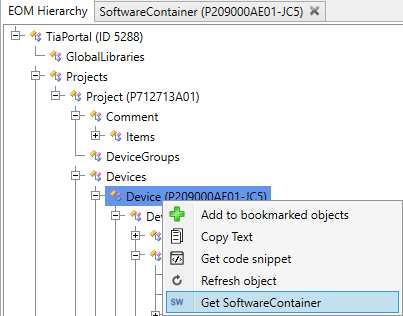

In [11]:
# needed modules: Siemens.Engineering, Siemens.Engineering.HW.Features
software_container = PLC_List[0].GetService[hwf.SoftwareContainer]() # Get the plc software of the first plc in the list - equivalent of the gui picture above
plc_software = software_container.Software # Get the software of the plc out of the software container

print(plc_software.Name) # Print the name of the software and the parent of the software

P209000AE01-JC5


In [12]:
'''
retrieving every program block in the plc, and linking it to the group it is in
find method to find the location of a certain program-block in the plc
'''

def get_blocks(group, blocks={}): # Recursive function to get all the blocks in the group
    if blocks is None:
        blocks = {}
    if group not in blocks: # Instance group is in more than one group, so we need to check if the group is already in the dictionary
        blocks[group] = []
    blocks[group].extend([block for block in group.Blocks])
    for sub_group in group.Groups:
        get_blocks(sub_group, blocks)
    return blocks

def list_blocks(blocks):
    for group_name, block_name in blocks.items():
        print(group_name.Name)
        for block in block_name:
            print('\t', block.Name)

def find_block_group(block_name):
    blocks_dict = get_blocks(plc_software.BlockGroup)
    for group, block_list in blocks_dict.items():
        for block in block_list:
            if block.Name == block_name:
                return group

blocks_dict = get_blocks(plc_software.BlockGroup)
list_blocks(blocks_dict)

block_to_find = 'F209220ZS01Output'
location = find_block_group(block_to_find)
print(f'\nblocklocation of {block_to_find} in tia : {location.Parent.Parent.GetAttribute("Name")}\\{location.Parent.GetAttribute("Name")}\\{location.Name}\\{block_to_find}') # optimaliseren manier om de locatie van een block te vinden

Program blocks
	 Changes
PLC OB:s
	 CYC_Proc
	 COMPLETE RESTART
	 CYCL_FLT
	 HW_INT0
	 I/O_FLT1
	 I/O_FLT2
	 MOD_ERR
	 PROG_ERR
	 RACK_FLT
	 CYC_INT2
	 FOB_RTG
	 CYC_INT5
	 209000NCP01
	 Cyclic interrupt
_PLC209 DB:s
General
ComVD
	 _209000NCP01ComVD
Alarm Communication
	 _209000NCP01VDComMasterAlarmReportSnd
	 _209000NCP01VDComMasterAlarmReportRcv
	 _209000NCP01VDComLocalAlarmReportRcv
	 _209000NCP01VDComLocalAlarmReportSnd
	 _209000NCP01Alarm
Instance
	 _209000NCP01VDMasterAlarmReport
	 _209000NCP01AlarmHandler
Event Communication
Instance
PhoneCall Communication
Instance
VIDS Communication
	 _209000NCP01VDComMasterVIDSRcv
	 _209000NCP01VDComMasterVIDSSnd
	 _209210NCB01VDComLocalVIDSRcv
	 _209210NCB01VDComLocalVIDSSnd
	 _209210NCB02VDComLocalVIDSRcv
	 _209220NCB02VDComLocalVIDSSnd
	 _209220NCB01VDComLocalVIDSRcv
	 _209210NCB02VDComLocalVIDSSnd
	 _209220NCB02VDComLocalVIDSRcv
	 _209220NCB01VDComLocalVIDSSnd
	 _209230NCB01VDComLocalVIDSRcv
	 _209230NCB01VDComLocalVIDSSnd
Instance
	 _20

## 3. Network Parameters - Ethernet addresses
Documentation:
- https://support.industry.siemens.com/forum/be/en/posts/accessing-nodes-openness/255511
    
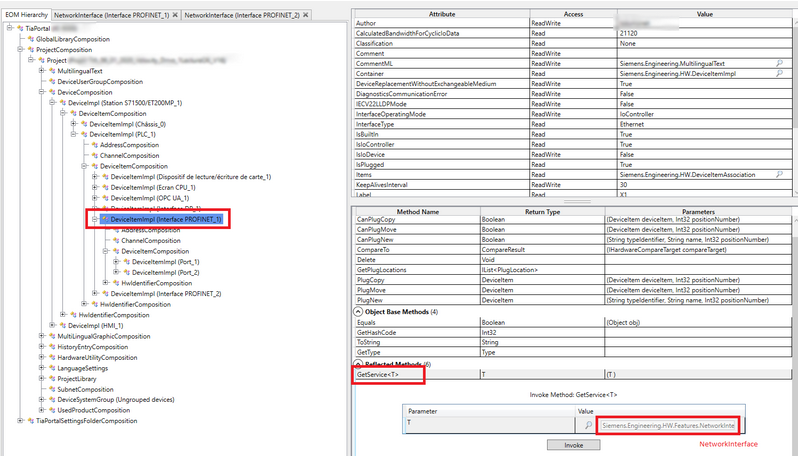

### Finding attributes with the corresponding service of device, for example NetworkInterface:

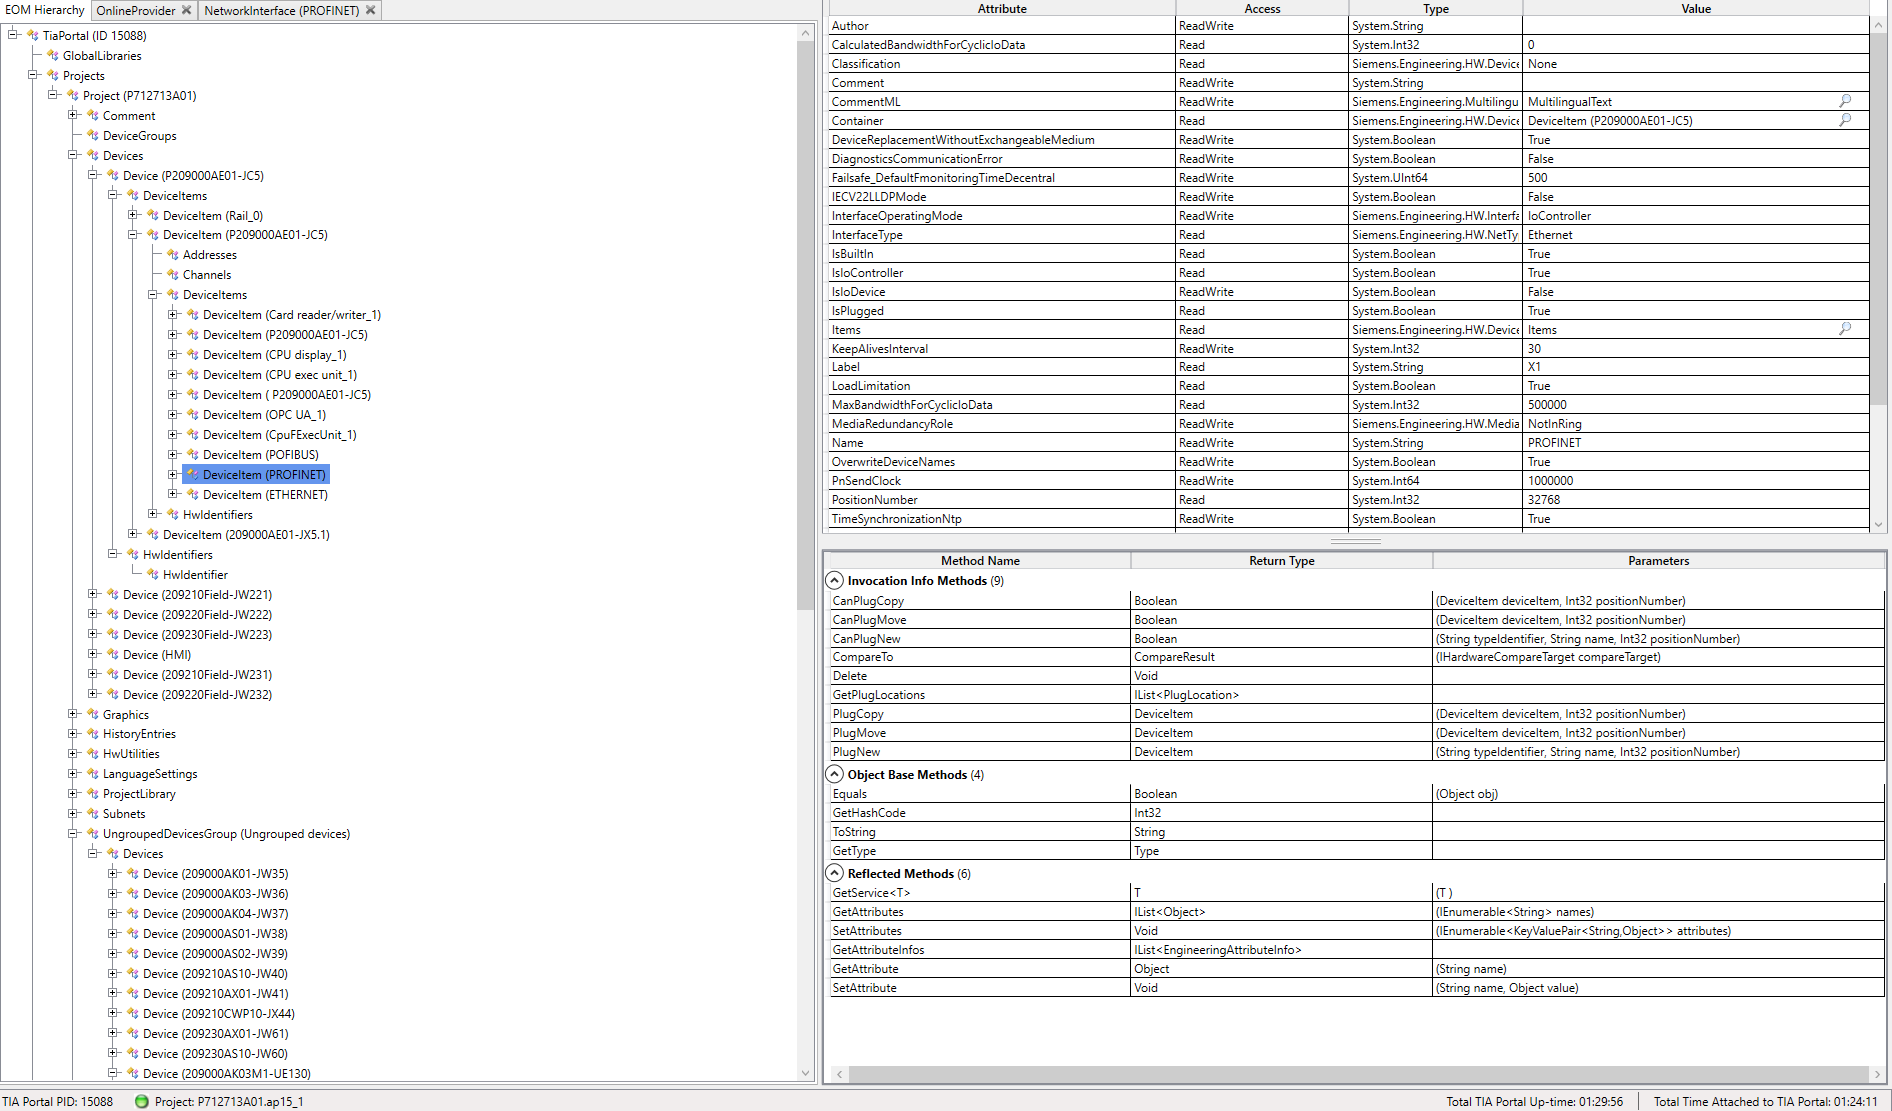

Execute the code below to find all devices with networkinterface

if you lookup a name ex. "PROFINET" in openess explore and use the GetService methode for network interface u'll see all the corresponding attributes

In [13]:
# Import the HW Features
import Siemens.Engineering.HW.Features as hwf 

interface_devices = []

for deviceitem in projectItems: # for all the devices and deviceItems in the project
    network_service = tia.IEngineeringServiceProvider(deviceitem).GetService[hwf.NetworkInterface]() # get the interface service
    if type(network_service) == hwf.NetworkInterface: # check wether the service do excist
        interface_devices.append(deviceitem)
        print(network_service.GetAttribute('Name')) # print the name of all the items with an interface-service

209220AX01-JW51
209230CA21M4-UE150
209000AE02-JW208.X1
209210CHB21M14-UE134
209210Field-JW221
209000AS02-JW39
209230Field-JW223
209000AK02-JC32
209000AS01-JW38
209000AK04M4-UE142
209230CHB21M14-UE151
209230CHB22M14-UE152
209210AS10-JW40
ETHERNET
209230AX01-JW61
209000AE02-JW71
209000AK03M4-UE132
209220AS11-JW52
209220AS10-JW50
209220CWP10-JX54
209220CHB21M14-UE144
209000AK03M1-UE133
209220AS20-JW58
211212AE1-JW200
209210CWP10-JX44
209000AK03-JW36
209220CWP10-JX55
209000AK04M4-UE141
POFIBUS
209210CWP10-JX45
209210AX01-JW41
209220Field-JW232
209000AE02-JW210
209220CWP10-JX57
209000AK01-JW35
209210CWP20-JX46
209000AE01-JC31
209000AK04M1-UE143
209000AE02-JW70
209210Field-JW231
209210CWP20-JX47
209220CWP20-JX56
209000AK03M4-UE131
209000AK03M1-UE130
209000AK04-JW37
209220AX02-JW53
209230AS10-JW60
209210AS20-JW48
209000AK04M1-UE140
209000AK01E1-BE30
PROFINET
209000AE02-JW208.X2
209210AX02-JW43
209000AE02-JW211
209220Field-JW222
209210AS11-JW42
PROFINET interface
209230CR22M1-UE153
209230ASD01

Idee schetsen van hoe de Profinet data eruit zou moeten zien
```python
n_interfaces = {
	"plc_name": {
		"subnetmask": '',
		"gateway": '',
		"devices": [
			{
				'device_name': [
					{
						"nodes": {
							'node_name': 'ip_value'
						}
					}
				]
			}
		]
	}
}
```

In [14]:
# NEEDS TO BE UPDATED AS NEXT NETWORK TROUGH SUBNETS THERE IS MORE THAN 1 NETWORK

# Needed modules : collections ordereddict
def getNodeList(items={}):
	'''
	gives a dictionary with all the plc's and their network information with the connected devices and their nodes
	'''
	PLC_List = get_plc_devices(projectItems)

	for plc in PLC_List:
		this_plc_name = plc.Name
		items[this_plc_name] = od()
		items[this_plc_name]["Network"] = {} # Initialize an empty "Network" key to ensure it's the first key
		items[this_plc_name]["devices"] = []

		this_plc_dict = items[this_plc_name]
		devices_list = this_plc_dict["devices"]

		for device in interface_devices:
			network_service = tia.IEngineeringServiceProvider(device).GetService[hwf.NetworkInterface]()

			if not isinstance(network_service, hwf.NetworkInterface): # skip the device if it does not have a network interface
				continue
					
			this_device_name = device.Name
			this_device_list = []

			if (device.Name == "PROFINET"):
				this_plc_subnet = network_service.Nodes[0].GetAttribute("SubnetMask")
				this_plc_gateway = network_service.Nodes[0].GetAttribute("RouterAddress")

				items[this_plc_name]["Network"] = { # update the network key with values
				"subnetmask" : this_plc_subnet,
				"gateway" : this_plc_gateway
				}

			this_nodes_dict = {}
			
			for index in range(network_service.Nodes.Count):
					this_node_name = network_service.Nodes[index].GetAttribute("Name")
					this_node_address = network_service.Nodes[index].GetAttribute("Address")

					this_nodes_dict[this_node_name] = this_node_address # add node to the dictionary
			
			this_device_list.append({"nodes" : this_nodes_dict}) # bundle all the nodes in the corresponding device	
			devices_list.append({this_device_name : this_device_list})

	return items

def find_device_nodes(plcName, deviceName, items):
	'''
	returns the nodes of a device
	'''
	try:
		plc_i_need = items[plcName]
		device_list = plc_i_need['devices']
		device_i_search = None

		for device_dict in device_list:
			if deviceName in device_dict.keys():
				device_i_search = device_dict[deviceName][0]['nodes']
				return f"Device \'{deviceName}\' in plc \'{plcName}\' has been found with the following nodes: {device_i_search}"
		return f"Device {deviceName} not found in plc {plcName}"
	except KeyError:
		return f"PLC {plcName} not found"
	
def address_exists(address, items):
	'''
	checks if an address is already in use
	'''
	for plc_name, plc_info in items.items(): # key-value pair in plc dictionary, returns list
		for device in plc_info['devices']: # device is dictionary, plc_info['devices'] is list
			for device_name, device_info in device.items():
				nodes = device_info[0]['nodes']  # gives the dictionary with the nodes key
				if address in nodes.values():  # checking if a value of a node is equal to the input address
						node_name = [name for name, ip in nodes.items() if ip == address]  # Vind de node_name
						return f"Address \'{address}\' is already in use by {node_name} in device \'{device_name}\' in plc \'{plc_name}\'"
	return f"Address \'{address}\' is not in use"

print(json.dumps(getNodeList(), indent=2)) # print the dictionary of all interface devices in a readable format

{
  "P209000AE01-JC5": {
    "Network": {
      "subnetmask": "255.255.255.0",
      "gateway": "10.210.79.1"
    },
    "devices": [
      {
        "209220AX01-JW51": [
          {
            "nodes": {
              "IE1": "10.210.79.51"
            }
          }
        ]
      },
      {
        "209230CA21M4-UE150": [
          {
            "nodes": {
              "IE1": "10.210.79.150"
            }
          }
        ]
      },
      {
        "209000AE02-JW208.X1": [
          {
            "nodes": {
              "IE1": "10.210.79.208"
            }
          }
        ]
      },
      {
        "209210CHB21M14-UE134": [
          {
            "nodes": {
              "IE1": "10.210.79.134"
            }
          }
        ]
      },
      {
        "209210Field-JW221": [
          {
            "nodes": {
              "IE1": "10.210.79.221"
            }
          }
        ]
      },
      {
        "209000AS02-JW39": [
          {
            "nodes": {
           

In [15]:
# Needed modules : collections ordereddict
def getNodeList(items={}, tia):
	'''
	gives a dictionary with all the plc's and their network information with the connected devices and their nodes
	'''
	PLC_List = get_plc_devices(projectItems)

	for plc in PLC_List:
		this_plc_name = plc.Name
		items[this_plc_name] = od()

		subnet_container = myinterface.Projects[0].Project.Subnets
		aantal_subnets = subnet_container.count()

		for subnet in range(aantal_subnets):
			subnet_name = subnet_container[subnet].GetAttribute("Name")
			subnet_mask = subnet_container[subnet].GetAttribute("Nodes")[0].GetAttribute("SubnetMask")
			subnet_gateway = subnet_container[subnet].GetAttribute("Nodes")[0].GetAttribute("RouterAddress")

			items[this_plc_name]["Network"] = {"subnet_name" : subnet_name, "subnetmask" : subnet_mask, "gateway" : subnet_gateway} 
			items[this_plc_name]["devices"] = []

			this_plc_dict = items[this_plc_name]
			devices_list = this_plc_dict["devices"]

			for node in


			for device in interface_devices:
				network_service = tia.IEngineeringServiceProvider(device).GetService[hwf.NetworkInterface]()

				if not isinstance(network_service, hwf.NetworkInterface): # skip the device if it does not have a network interface
					continue
						
				this_device_name = device.Name
				this_device_list = []
				this_nodes_dict = {}
				
				for index in range(network_service.Nodes.Count):
					this_node_name = network_service.Nodes[index].GetAttribute("Name")
					this_node_address = network_service.Nodes[index].GetAttribute("Address")

					this_nodes_dict[this_node_name] = this_node_address # add node to the dictionary
				
				this_device_list.append({"nodes" : this_nodes_dict}) # bundle all the nodes in the corresponding device	
				devices_list.append({this_device_name : this_device_list})

	return items

def find_device_nodes(plcName, deviceName, items):
	'''
	returns the nodes of a device
	'''
	try:
		plc_i_need = items[plcName]
		device_list = plc_i_need['devices']
		device_i_search = None

		for device_dict in device_list:
			if deviceName in device_dict.keys():
				device_i_search = device_dict[deviceName][0]['nodes']
				return f"Device \'{deviceName}\' in plc \'{plcName}\' has been found with the following nodes: {device_i_search}"
		return f"Device {deviceName} not found in plc {plcName}"
	except KeyError:
		return f"PLC {plcName} not found"
	
def address_exists(address, items):
	'''
	checks if an address is already in use
	'''
	for plc_name, plc_info in items.items(): # key-value pair in plc dictionary, returns list
		for device in plc_info['devices']: # device is dictionary, plc_info['devices'] is list
			for device_name, device_info in device.items():
				nodes = device_info[0]['nodes']  # gives the dictionary with the nodes key
				if address in nodes.values():  # checking if a value of a node is equal to the input address
						node_name = [name for name, ip in nodes.items() if ip == address]  # Vind de node_name
						return f"Address \'{address}\' is already in use by {node_name} in device \'{device_name}\' in plc \'{plc_name}\'"
	return f"Address \'{address}\' is not in use"

print(json.dumps(getNodeList(), indent=2)) # print the dictionary of all interface devices in a readable format

SyntaxError: non-default argument follows default argument (3959864976.py, line 2)

In [16]:
device_name = input("give the name of the device you want to find the nodes of: ").upper()
print(json.dumps(find_device_nodes(PLC_List[0].Name, device_name, getNodeList()), indent=2)) # find the nodes of the input device

"Device 'PROFINET' in plc 'P209000AE01-JC5' has been found with the following nodes: {'X1': '10.210.79.5'}"


In [17]:
address = input("give the address you want to check: ")
while True:
    if not (7 <= len(address) <= 16): # Check if the address length is within the desired range, min 0.0.0.0 and max 255.255.255.255
        print("Invalid input: Address length is not within the valid range.")
    elif any(char not in "0123456789." for char in address): # Check if the address contains only numbers and dots
        print("Invalid input: Address contains invalid characters.")
    else:
        break  # Address is valid, exit the loop
    
    address = input("Give the address you want to check: ")

address_exists(address, getNodeList()) # check if the input address is already in use

"Address '1.1.1.1' is not in use"

In [19]:
cwd = os.getcwd()
directory = os.makedirs(cwd + "\\Nodes", exist_ok=True) # Create a directory to store the nodes in

nodesTable = pd.DataFrame()
for plc_name, plc_info in getNodeList().items():
    network_segment = pd.DataFrame({
        'plc_name': [plc_name],  # Enclose scalar values in lists to ensure they are treated as single-element columns
        'subnetmask': [plc_info['Network']['subnetmask']],
        'gateway': [plc_info['Network']['gateway']],
    }, index=[0])  
    
    for device in plc_info['devices']:
        for device_name, device_info in device.items():
            node_names = [node for node in device_info[0]['nodes'].keys()]

            # make a DataFrame for the device and concatenate it to the network_segment
            device_df = pd.DataFrame({
                'device_name': [device_name],
                'node_names': node_names,
                'node_addresses': [device_info[0]['nodes'][node] for node in node_names]
            }, index=[0])  # Enclose scalar values in lists to ensure they are treated as single-element columns
            
            network_segment = pd.concat([network_segment, device_df], ignore_index=True)
    
    # Concatenate all network_segments to nodesTable
    nodesTable = pd.concat([nodesTable, network_segment], ignore_index=True)

export_path = os.path.join(cwd, 'Nodes', 'NodesTable.csv')
nodesTable.to_csv(export_path, index=False)	# Export the DataFrame to a CSV file

print(f"Nodes table exported to {export_path}")
print(nodesTable.to_string())

Nodes table exported to c:\Users\QBAUWENS\Documents\Openess\Nodes\NodesTable.csv
           plc_name     subnetmask      gateway           device_name node_names node_addresses
0   P209000AE01-JC5  255.255.255.0  10.210.79.1                   NaN        NaN            NaN
1               NaN            NaN          NaN       209220AX01-JW51        IE1   10.210.79.51
2               NaN            NaN          NaN    209230CA21M4-UE150        IE1  10.210.79.150
3               NaN            NaN          NaN   209000AE02-JW208.X1        IE1  10.210.79.208
4               NaN            NaN          NaN  209210CHB21M14-UE134        IE1  10.210.79.134
5               NaN            NaN          NaN     209210Field-JW221        IE1  10.210.79.221
6               NaN            NaN          NaN       209000AS02-JW39        IE1   10.210.79.39
7               NaN            NaN          NaN     209230Field-JW223        IE1  10.210.79.223
8               NaN            NaN          NaN       2

## 3. GUI

In [4]:
import InitTiaProject as Init
import subprocess
from tkinter import *
from tkinter import messagebox

# global variables to store the project and interface
global myproject, myinterface
myproject, myinterface = None, None
action_label = None

def stop_siemens_processes():
    command = 'Get-Process | Where-Object {$_.ProcessName -like "Siemens*"} | Stop-Process -Force'
    try:
        subprocess.run(["powershell", "-Command", command], check=True)
        print("Siemens processes stopped successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while stopping Siemens processes: {e}")

def update_action_label(text):
    global action_label
    if action_label is None:
        action_label = Label(root, text=text)
        action_label.grid(row=3, column=4)
    else:
        action_label.config(text=text)
    return

def open_project():
    global myproject, myinterface, action_label  # Ensure these are accessible globally
    try:
        update_action_label("Project is opening, please wait...")
        root.update_idletasks()
        
        project_path = project_path_entry.get()
        myproject, myinterface = Init.open_project(False, project_path)
        update_action_label("Project opened successfully!")
        root.update_idletasks()
        return myproject, myinterface
  
    except Exception as e:
        update_action_label(f"Error: project could not be opened. {e}")
        

def close_project():
    global myproject, myinterface, action_label  # Ensure these are accessible globally
    try:
        if myproject and myinterface:
            Init.close_project(myproject, myinterface)
            myproject, myinterface = None, None  # Reset project variables to None after closing
            update_action_label("Project closed successfully!")
        else:
            response = messagebox.askyesno("Force closing project", "would you like to force close any project opened in a previous session?")
            if response:
                stop_siemens_processes()
                update_action_label("Siemens processes stopped successfully.")
            else:
                update_action_label("Operation cancelled by user.")
    except Exception as e:
        update_action_label("Error: project could not be closed. No project is opened.")

# Create the main window
root = Tk()
root.title("Tia Openess")
root.iconbitmap('img\\tia.ico')
root.geometry('1500x1000')

##- adding a label to the window
project_path_label = Label(root, text="insert project path:") 

##- adding an entry to the window
project_path_entry = Entry(root, width=100)

##- adding a button to the window
open_project_button = Button(root, text="Open project", command= open_project)
close_project_button = Button(root, text="Close project", command= close_project)

##- displaying
project_path_label.grid(row=0, column=0) 
project_path_entry.grid(row=0, column=1)

open_project_button.grid(row=0, column=4)
close_project_button.grid(row=1, column=4)

root.mainloop() ##- keep the window open


Siemens processes stopped successfully.


In [8]:
#Closing Project
Init.close_project(myproject, myinterface)

AttributeError: 'NoneType' object has no attribute 'Close'

: 